In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

old_metrics = json.load(open('old.json'))
zhang_metrics = json.load(open('zhang.json'))
aste_prompt_metrics = json.load(open('aste_prompt.json'))
pabsa_metrics = json.load(open('pabsa.json'))

old_predictions = pd.read_csv('old.csv')
zhange_predictions = pd.read_csv('zhang.csv')
aste_prompt_predictions = pd.read_csv('aste_prompt.csv')
pabsa_predictions = pd.read_csv('pabsa.csv')

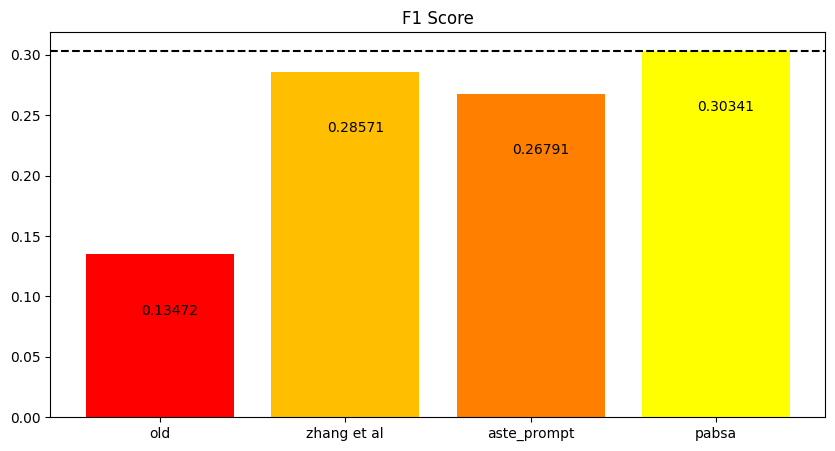

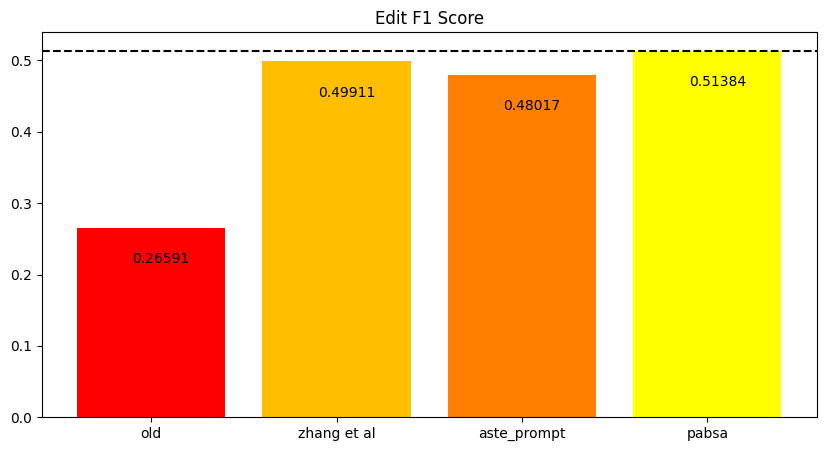

In [57]:
# Bar plot the 'f1' and 'edit_f1' metrics for each model

# colors gradient from red to green 4 element
color = ['#ff0000', '#ffbf00', '#ff8000', '#ffff00']

plt.figure(figsize=(10, 5))
plt.bar(['old', 'zhang et al', 'aste_prompt', 'pabsa'], [old_metrics['f1'], zhang_metrics['f1'], aste_prompt_metrics['f1'], pabsa_metrics['f1']], color=color)
# add horizontal stripped line for max f1
plt.axhline(y=max([old_metrics['f1'], zhang_metrics['f1'], aste_prompt_metrics['f1'], pabsa_metrics['f1']]), color='black', linestyle='dashed')
# write the value in each bar
for i, v in enumerate([old_metrics['f1'], zhang_metrics['f1'], aste_prompt_metrics['f1'], pabsa_metrics['f1']]):
    plt.text(i - 0.1, v - 0.05, str(round(v, 5)))
plt.title('F1 Score')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(['old', 'zhang et al', 'aste_prompt', 'pabsa'], [old_metrics['edit_f1'], zhang_metrics['edit_f1'], aste_prompt_metrics['edit_f1'], pabsa_metrics['edit_f1']], color=color)
# add horizontal stripped line for max edit_f1
plt.axhline(y=max([old_metrics['edit_f1'], zhang_metrics['edit_f1'], aste_prompt_metrics['edit_f1'], pabsa_metrics['edit_f1']]), color='black', linestyle='dashed')
# write the value in each bar
for i, v in enumerate([old_metrics['edit_f1'], zhang_metrics['edit_f1'], aste_prompt_metrics['edit_f1'], pabsa_metrics['edit_f1']]):
    plt.text(i - 0.1, v - 0.05, str(round(v, 5)))
plt.title('Edit F1 Score')
plt.show()

In [3]:
def unique(triplets):
    result = []
    for t in triplets:
        if t not in result:
            result.append(t)
    return result

def equal_target_and_pred(target,pred):
    target = eval(target)
    pred = eval(pred)

    target = unique(target)
    pred = unique(pred)

    if len(pred) != len(target):
        return False
    
    for t in target:
        if t not in pred:
            return False
    return True

def unequal_target_and_pred(target,pred):
    return not equal_target_and_pred(target,pred)

In [7]:
unequal_old = old_predictions.loc[old_predictions.apply(lambda x : unequal_target_and_pred(x['target'],x['preds']),axis=1)].copy()
unequal_zhang = zhange_predictions.loc[zhange_predictions.apply(lambda x : unequal_target_and_pred(x['target'],x['prediction']),axis=1)].copy()
unequal_aste_prompt = aste_prompt_predictions.loc[aste_prompt_predictions.apply(lambda x : unequal_target_and_pred(x['target'],x['prediction']),axis=1)].copy()
unequal_pabsa = pabsa_predictions.loc[pabsa_predictions.apply(lambda x : unequal_target_and_pred(x['target'],x['prediction']),axis=1)].copy()

In [8]:
print("False old :",unequal_old.shape[0])
print("False zhang :",unequal_zhang.shape[0])
print("False aste prompt :",unequal_aste_prompt.shape[0])
print("False pabsa :",unequal_pabsa.shape[0])

False old : 95
False zhang : 126
False aste prompt : 124
False pabsa : 120


In [14]:
print("False old (not blank):",unequal_old.loc[unequal_old.target != '[]'].shape[0])
print("False zhang (not blank):",unequal_zhang.loc[unequal_zhang.target != '[]'].shape[0])
print("False aste prompt (not blank):",unequal_aste_prompt.loc[unequal_aste_prompt.target != '[]'].shape[0])
print("False pabsa (not blank):",unequal_pabsa.loc[unequal_pabsa.target != '[]'].shape[0])

False old (not blank): 88
False zhang (not blank): 80
False aste prompt (not blank): 78
False pabsa (not blank): 77


In [5]:
from transformers import T5Tokenizer
model_path = "/srv/nas_data1/text/randy/absa/models/facebook_research/generative/t5/Wikidepia_IndoT5-small/prosa/t5_pabsa_S256_small_blank=1.0"
tokenizer = T5Tokenizer.from_pretrained(model_path)

/home/randy.suchrady/anaconda3/envs/absa/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
def n_token(text, prompt):
    return len(tokenizer.tokenize(prompt + " " + text))

In [33]:
unequal_pabsa["n_token"] = unequal_pabsa.apply(lambda x : n_token(x["text"],x["prompt"]),axis=1)

In [35]:
unequal_pabsa.n_token.max()

356

In [36]:
unequal_pabsa.loc[unequal_pabsa.n_token == 356]

,text,prompt,target,prediction,string_preds,n_token
275,""" IMDP telah menangkap seorang pria yang menco...",ekstraksi triplet aste :,"[{'aspect': 'pria', 'opinion': 'mencoba melewa...","[{'aspect': 'konser Doja Cat', 'opinion': 'sem...","( konser Doja Cat, sempat tertunda, negative )...",356


In [19]:
sample = unequal_pabsa.sample(10)

In [43]:
sample.to_csv('sample_error_analysis.csv',index=False)

In [38]:
import re

str_pattern = r'\(\s?(.+)\s?,\s?(.+)\s?,\s?(positive|negative|neutral)\s?\)'
str_pattern = f"{str_pattern}\s?;?\s?({str_pattern})*|NONE"
pattern = re.compile(str_pattern)

In [47]:
unequal_pabsa.loc[~unequal_pabsa.string_preds.apply(lambda x : bool(pattern.match(x)))]

,text,prompt,target,prediction,string_preds
124,[ Gambas : Video CNN ] Menteri Energi dan Sumb...,ekstraksi triplet aste :,"[{'aspect': 'PT PLN ( Persero )', 'opinion': '...",[],"( PT PLN ( Persero ), krisis gas alam cair ( l..."


In [51]:
unequal_pabsa.loc[124].text

'[ Gambas : Video CNN ] Menteri Energi dan Sumber Daya Mineral ( ESDM ) Arifin Tasrif mengungkapkan PT PLN ( Persero ) sempat mengalami krisis gas alam cair ( liquefied natural gas / LNG ) .'

In [55]:
unequal_pabsa.loc[124].string_preds

'( PT PLN ( Persero ), krisis gas alam cair ( liquefied natural gas / LNG ), krisis gas alam cair ( liquefied natural gas / LNG ), krisis gas alam cair, krisis gas alam cair, krisis gas alam cair, krisis gas alam cair, krisis gas alam cair, krisis gas alam cair, krisis gas alam cair, krisis gas alam cair, krisis gas alam cair, krisis gas alam cair, krisis gas alam cair, krisis gas alam cair, krisis gas alam cair, krisis gas alam cair, krisis gas alam cair, krisis gas alam cair, krisis gas alam cair, krisis gas alam cair, krisis gas alam cair, krisis gas alam cair, krisis gas alam cair, krisis gas alam cair, krisis gas alam cair, krisis gas alam cair, LNG, krisis gas alam cair, LNG, krisis gas alam cair, LNG, krisis gas alam cair, LNG, krisis gas alam cair, LNG, krisis gas alam cair, LNG, krisis gas alam'

In [56]:
unequal_pabsa.loc[124].target

"[{'aspect': 'PT PLN ( Persero )', 'opinion': 'sempat mengalami krisis gas alam cair ( liquefied natural gas / LNG )', 'sentiment': 'negative'}]"